### - Sobhan Moradian Daghigh
#### - DIP - Final Project
#### - Date: 7-13-2022
Implementation of [this](https://doi.org/10.48550/arXiv.1405.4930) paper: Adapted Approach for Fruit Disease Identification using Images

### Import Libraries

In [126]:
import numpy as np
import glob
import cv2
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.svm import SVC

### Load Dataset

In [5]:
def load_datas(path):
    folders = glob.glob('{}*'.format(path))
    
    x_train, y_train = [], []
    x_test,  y_test  = [], []
    
    for folder in folders:
        classes = glob.glob('{}/*'.format(folder))
        
        for class_ in classes:            
            images = glob.glob('{}/*.jpg'.format(class_))
            
            for image in images:
                img = cv2.imread(image)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                set_name = folder.split('\\')[-1]
                label = class_.split('\\')[-1] if not 'demo' in image.split('\\')[-1] else image.split('\\')[-1][:-4]
                (x_train.append(img), y_train.append(label)) if set_name == 'Train' else (x_test.append(img), y_test.append(label))
    
    return [np.array(arr, dtype=object) for arr in [x_train, y_train, x_test, y_test]]

In [6]:
x_train, y_train, x_test, y_test = load_datas('./apple_disease_dataset/')
x_train.shape, x_test.shape

((380,), (119,))

### Shuffle Data

In [7]:
def shuffler(arrays):
    shuffled = []
    np.random.seed(0)
    indices = np.arange(arrays[0].shape[0])
    np.random.shuffle(indices)
    for arr in arrays:
        shuffled.append(arr[indices])
    return shuffled

In [8]:
x_train, y_train = shuffler(arrays=[x_train, y_train])
x_test,  y_test  = shuffler(arrays=[x_test,  y_test ])

### plotter

In [9]:
def plotter(images, names=None, subplots=None, gray=False):
    if subplots is None:
        plt.figure(figsize=(5, 6))
        plt.imshow(images, cmap='gray') if gray else plt.imshow(images)
        plt.title(names)
        plt.axis('off')
    else:
        fig, ax = plt.subplots(subplots[0], subplots[1], figsize=(subplots[1] * 5, subplots[0] * 4))
        for i, (img, name, ax) in enumerate(zip(images, names, fig.axes)):
            ax.imshow(img, cmap='gray') if gray else ax.imshow(img)
            ax.set_title(name)
            ax.axis('off')
    plt.show()

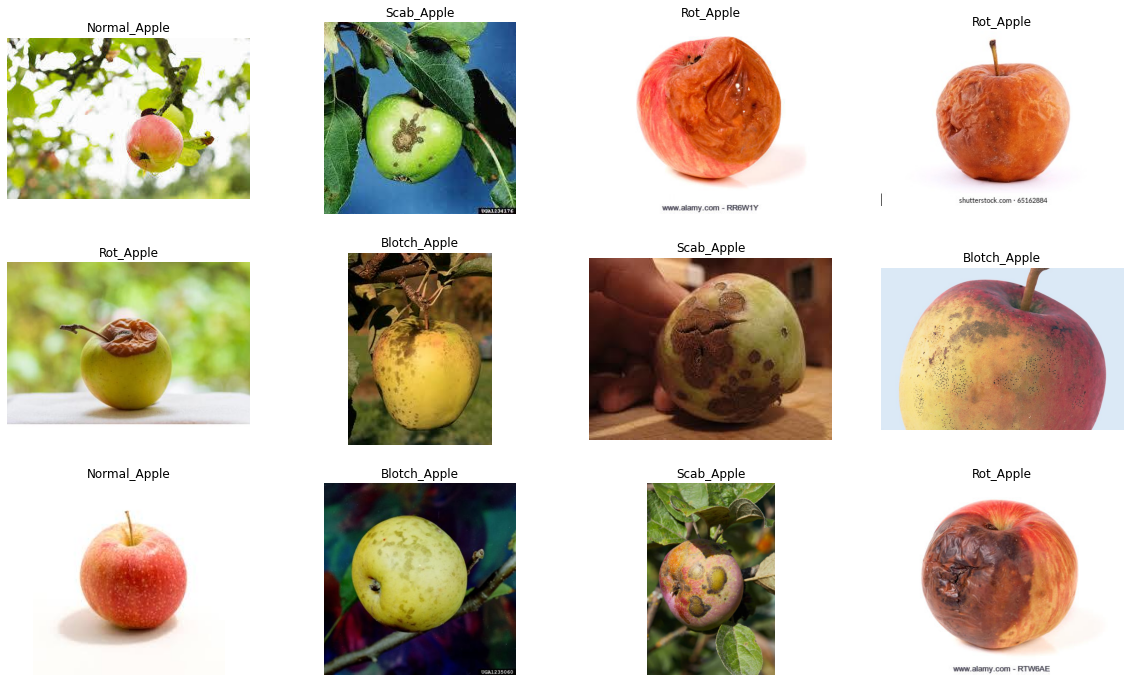

In [10]:
plotter(x_train[:12], y_train[:12], subplots=(3, 4))

### Change Color Space

In [11]:
def rgb2lab(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2Lab)

In [12]:
x_train_lab = list(map(rgb2lab, x_train))
x_test_lab  = list(map(rgb2lab, x_test ))

### Filter needed spaces
##### Here we need 'a' and 'b' in 'Lab*' color space.

In [31]:
def filter_channels(img, indices=[1, 2]):
    return img[:, :, indices]

In [32]:
# channels: 0:'L*', 1:'a*', 2:'b*'
x_train_ch12 = list(map(lambda img: filter_channels(img, indices=[1, 2]), x_train_lab))
x_test_ch12  = list(map(lambda img: filter_channels(img, indices=[1, 2]), x_test_lab ))

### Flatten
##### 2D image array into an MxN feature vector, where M is the number of pixels and N is the dimension (number of channels)

In [15]:
def flatten(img):
    img = np.array(img)
    return img.reshape(img.shape[0] * img.shape[1], img.shape[2])

In [16]:
x_train_flatten = list(map(flatten, x_train_ch12))
x_test_flatten  = list(map(flatten, x_test_ch12 ))

### Preprocessor

In [38]:
def preprocessor(img):
    lab = rgb2lab(img)
    ch12 = filter_channels(lab)
    flat = flatten(ch12)
    return flat

### K-means clustering

In [17]:
n_clusters = 4
demo_idx = np.where(y_train == 'demo')[0][0]
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(x_train_flatten[demo_idx])

In [18]:
img = np.array(x_train[demo_idx])

In [19]:
clustering = np.reshape(np.array(kmeans.labels_, dtype=np.uint8), (img.shape[0], img.shape[1]))
sortedLabels = sorted([n for n in range(n_clusters)], key=lambda x: -np.sum(clustering == x))

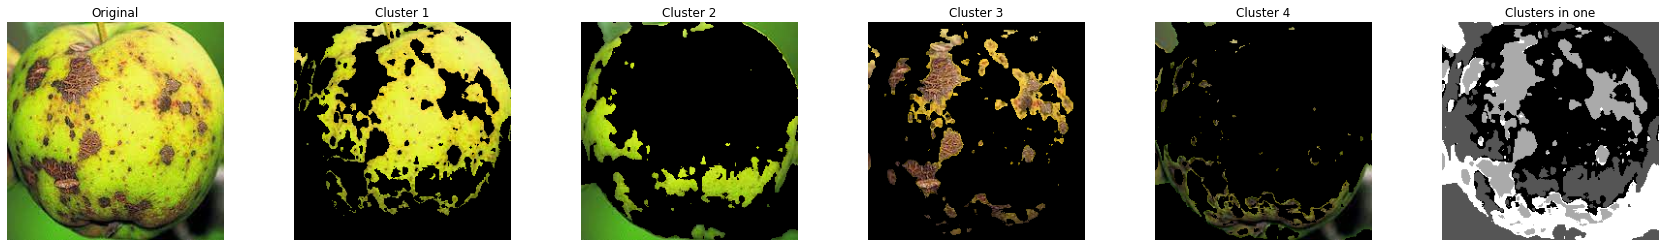

In [20]:
results = []
results.append(img)
single_gray = np.zeros(img.shape[:2], dtype=np.uint8)

for i, label in enumerate(sortedLabels):
    single_gray[clustering == label] = int((255) / (n_clusters - 1)) * i
    image = img.copy()
    kmeansImage = np.zeros(img.shape[:2], dtype=np.uint8)
    kmeansImage[clustering == label] = 1    
    xs = np.where(kmeansImage == 0)[0]
    ys = np.where(kmeansImage == 0)[1]
    for x, y in zip(xs, ys):
        image[x, y] = [0, 0, 0]
    results.append(image)
results.append(single_gray)
plotter(results, names=['Original', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Clusters in one'], subplots=(1, 6), gray=True) 

In [59]:
def k_means_segmentation(img, n_clusters=4):

    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(preprocessor(img))
    clustering = np.reshape(np.array(kmeans.labels_, dtype=np.uint8), (img.shape[0], img.shape[1]))
    sortedLabels = sorted([n for n in range(n_clusters)], key=lambda x: -np.sum(clustering == x))
    
    results = []
    results.append(img)
    single_gray = np.zeros(img.shape[:2], dtype=np.uint8)

    for i, label in enumerate(sortedLabels):
        single_gray[clustering == label] = int((255) / (n_clusters - 1)) * i
        image = img.copy()
        kmeansImage = np.zeros(img.shape[:2], dtype=np.uint8)
        kmeansImage[clustering == label] = 1    
        xs = np.where(kmeansImage == 0)[0]
        ys = np.where(kmeansImage == 0)[1]
        for x, y in zip(xs, ys):
            image[x, y] = [0, 0, 0]
        results.append(image)
    results.append(single_gray)
    plotter(results, names=['Original', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Clusters in one'], subplots=(1, 5), gray=True) 

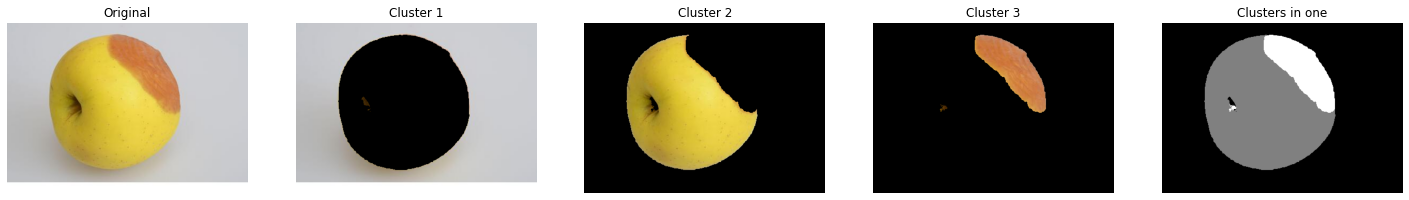

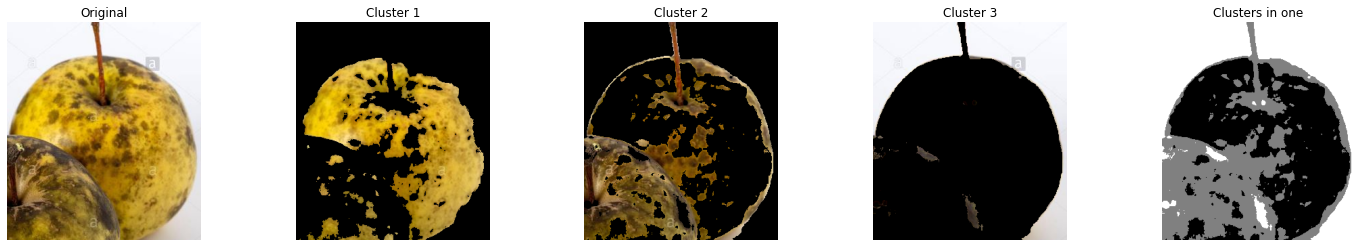

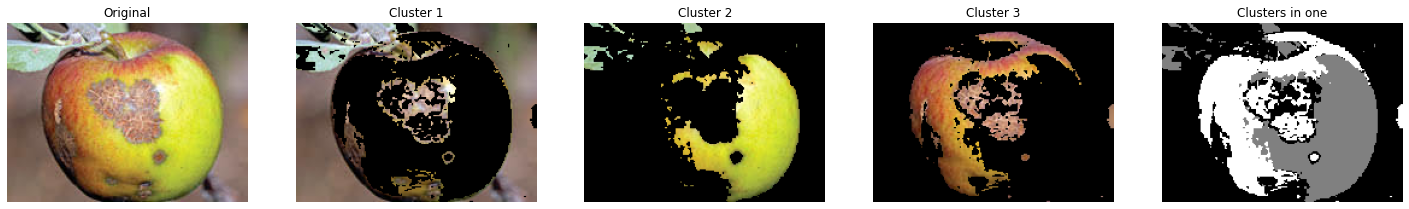

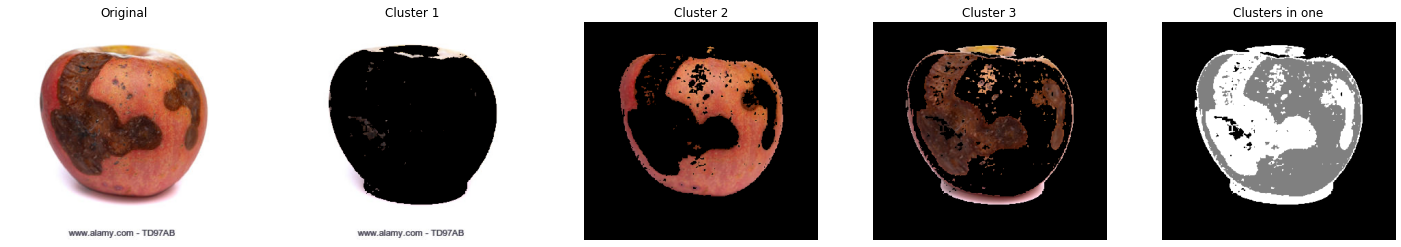

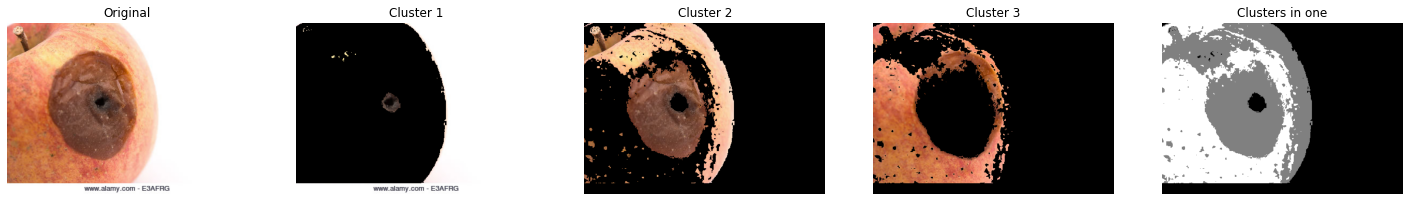

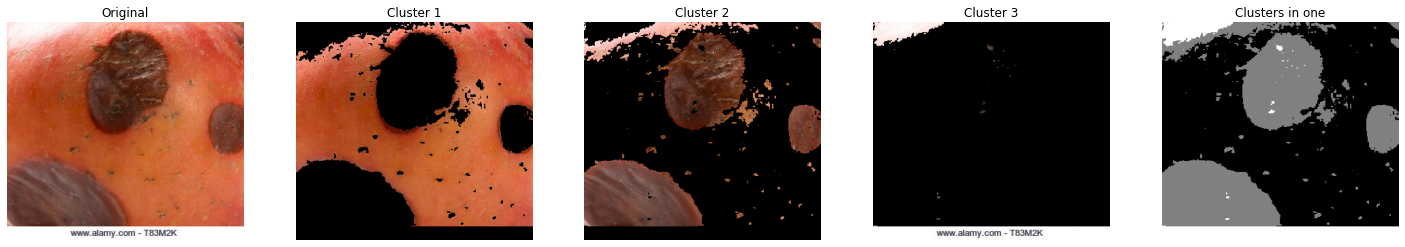

In [60]:
for img in x_test[-16:-10]:
    k_means_segmentation(img, n_clusters=3)

In [114]:
def is_adjacent(x1, y1, x2, y2):
    ''' Returns true if (x1, y1) is adjacent to (x2, y2), and false otherwise '''

    x_diff = abs(x1 - x2)
    y_diff = abs(y1 - y2)
    return not (x_diff == 1 and y_diff == 1) and (x_diff <= 1 and y_diff <= 1)

def find_max_cliques(arr, n):
    ''' Returns a 2*n dimensional vector: coherent and incoherent pixels respectively a given color '''
    
    tau = int(arr.shape[0] * arr.shape[1] * 0.01)
    ccv = [0 for i in range(n**3 * 2)]
    unique = np.unique(arr)
    
    for u in unique:
        x, y = np.where(arr == u)
        groups = []
        coherent = 0
        incoherent = 0
        
        for i in range(len(x)):            
            found_group = False
            for group in groups:                
                if found_group:
                    break

                for coord in group:                    
                    xj, yj = coord
                    if is_adjacent(x[i], y[i], xj, yj):
                        found_group = True
                        group[(x[i], y[i])] = 1
                        break
                        
            if not found_group:
                groups.append({(x[i], y[i]): 1})
        
        for group in groups:
            num_pixels = len(group)
            if num_pixels >= tau:
                coherent += num_pixels
            else:
                incoherent += num_pixels
        
        assert(coherent + incoherent == len(x))
        
        index = int(u)
        ccv[index*2] = coherent
        ccv[index*2+1] = incoherent
    
    return ccv

In [115]:
def get_ccv(img, n):
    ''' Extracting the features '''
    
    # Blur pixel slightly using avg pooling with 3x3 kernel
    blur_img = cv2.blur(img, (3, 3))
    blur_flat = blur_img.reshape(img.shape[0] * img.shape[1], 3)
    
    # Discretize colors
    hist, edges = np.histogramdd(blur_flat, bins=n)
    
    graph = np.zeros((img.shape[0], img.shape[1]))
    result = np.zeros(blur_img.shape)
    
    total = 0 
    for i in range(0, n):
        for j in range(0, n):
            for k in range(0, n):
                rgb_val = [edges[0][i+1], edges[1][j+1], edges[2][k+1]]
                previous_edge = [edges[0][i], edges[1][j], edges[2][k]]
                coords = ((blur_img <= rgb_val) & (blur_img >= previous_edge)).all(axis=2)
                result[coords] = rgb_val
                graph[coords] = i + j * n + k * n**2
    
    result = result.astype(int)
    return find_max_cliques(graph, n) # image.flatten()

In [129]:
n = 2 # Indicating 2^3 discretized colors
feature_size = n**3 * 2 # Number of discretized colors * 2 for coherent and incoherent

def extract_features(img):
    print('done')
    return get_ccv(img, n)

In [130]:
img = np.resize(x_train[0], (64, 64, 3))
extract_features(img)

done


[85, 634, 0, 1, 0, 321, 351, 758, 0, 11, 0, 0, 0, 1, 1108, 826]

In [ ]:
'''
Blotch(B)
Normal(N)
Rot(R)
Scab(S)

 ----------------------------------------------
|        BxN   BxR   BxS   NxR   NxS   RxS     |
|    B   +1    +1    +1     0     0     0      |
|    N   -1     0     0    +1    +1     0      |
|    R    0    -1     0    -1     0    +1      |
|    S    0     0    -1     0    -1    -1      |
|                                              |
 ----------------------------------------------
'''

In [127]:
def prepare_features(dataset):
    datas = []
    for img in dataset:
        img = np.resize(img, (64, 64, 3))
        datas.append(extract_features(img))
    return datas

In [131]:
x_train_features = prepare_features(x_train)
x_test_features = prepare_features(x_test)

done
done
done
done
done
done
done


KeyboardInterrupt: 

### SVM

In [ ]:
svc_clf = SVC(kernel='rbf')
svc_clf.fit(x_train, y_train)
y_pred = svclassifier.predict(X_test)

In [ ]:
np.random.seed(1337)

num_classes = 4

train_data, train_labels = load_data(dataset="train", classes=classes)
test_data, test_labels = load_data(dataset="test", classes=classes)

batch_size = 16

lr = tf.placeholder(tf.float32, shape=[])
base_lr = 1

x = tf.placeholder(tf.float32, [None, feature_size]) # Placeholder for image input
y = tf.placeholder(tf.float32, [None, num_classes]) # Placeholder for labels

# Model parameters
# Weights and bias
w = tf.Variable(tf.zeros([feature_size, num_classes]))
b = tf.Variable(tf.zeros([num_classes]))

pred = tf.matmul(x, w) + b
cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=pred, labels=y))
# cost = tf.reduce_mean(tf.exp(-tf.reduce_sum(tf.multiply(tf.scalar_mul(2,y) - 1, pred), axis=1))) # Logistic loss
# cost = tf.reduce_mean(tf.maximum(1 - tf.multiply(tf.scalar_mul(2, y) - 1, pred), 0)) # Hinge loss
# cost = tf.reduce_mean(tf.losses.hinge_loss(y, pred))

optimizer = tf.train.GradientDescentOptimizer(lr).minimize(cost)

init = tf.global_variables_initializer()

# For early stopping
eps = 0.0001 # If loss decreases below this amount, stop training
last_loss = None
losses_to_consider = 5 # If the mean of the last 3 losses < eps, stop
losses = []

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(100):
        batch_start = 0
        batch_end = batch_size
        train_batch, train_label = train_data[batch_start:batch_end], train_labels[batch_start:batch_end]

        _, batch_cost = sess.run([optimizer, cost], feed_dict={x: train_batch,
                                                      y: train_label, lr: base_lr / (epoch+1)})
        losses.append(batch_cost)
        
        if epoch % 10 == 0:
            print("Epoch: {}, loss: {}".format(epoch+1, batch_cost))
        
        last_losses = np.mean(losses[-1-losses_to_consider:-1])

        if abs(last_losses) < eps:
            break
        
        # Shuffle data again
        train_data, train_labels = shuffle_data(train_data, train_labels)

    correct = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    print("Train accuracy:", accuracy.eval({x: train_data, y: train_labels}))
    print("Test accuracy:", accuracy.eval({x: test_data, y: test_labels}))